In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
class Maze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height, self.maze_width = maze.shape #get height and width of the maze
        self.start_position = start_position#set start position as tuple
        self.goal_position = goal_position

    def show_maze(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap='gray')
        #add start and end position 'S' & 'G'
        plt.text(self.start_position[1], self.start_position[0], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[1], self.goal_position[0], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()


In [3]:
# Actions: Up, Down, Left, Right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]


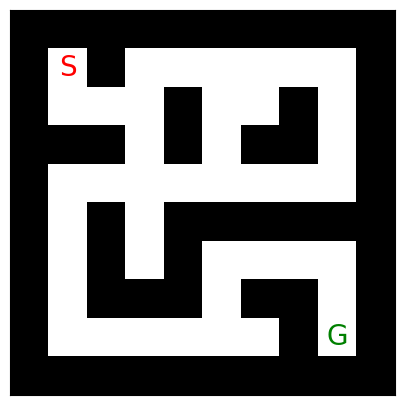

In [4]:
# Create any maze 
maze_layout = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

# Create an instance of the maze and set the starting and ending positions
maze = Maze(maze_layout, (1, 1), (8, 8))
maze.show_maze()

In [5]:
class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.9, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        return self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)

    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)
        if np.random.rand() < exploration_rate:
            return np.random.randint(4)
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, next_state, reward):
        best_next_action = np.argmax(self.q_table[next_state])
        current_q_value = self.q_table[state][action]
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)
        self.q_table[state][action] = new_q_value

In [6]:
#reward system
goal_reward = 100
wall_penalty = -10
step_penalty = -1

In [7]:
def finish_episode(agent, maze, current_episode, train=True):
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]

    while not is_done:
        action = agent.get_action(current_state, current_episode)
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        if (next_state[0] < 0 or next_state[0] >= maze.maze_height or 
            next_state[1] < 0 or next_state[1] >= maze.maze_width or 
            maze.maze[next_state[0]][next_state[1]] == 1):
            reward = wall_penalty
            next_state = current_state
        elif next_state == maze.goal_position:
            path.append(next_state)
            reward = goal_reward
            is_done = True
        else:
            path.append(next_state)
            reward = step_penalty

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action, next_state, reward)

        current_state = next_state

    return episode_reward, episode_step, path

In [8]:
def test_agent(agent, maze, num_episodes=1):
    episode_reward, episode_step, path = finish_episode(agent, maze, num_episodes, train=False)

    print("Learned Path:")
    for row, col in path:
        print(f"({row}, {col}) -> ", end='')
    print("Goal!")

    print(f"Number of steps: {episode_step}")
    print(f"Total reward: {episode_reward}")

    plt.figure(figsize=(5, 5))
    plt.imshow(maze.maze, cmap='gray')
    plt.text(maze.start_position[1], maze.start_position[0], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[1], maze.goal_position[0], 'G', ha='center', va='center', color='green', fontsize=20)

    for position in path:
        plt.text(position[1], position[0], "#", ha='center', va='center', color='blue', fontsize=20)

    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)
    plt.show()

    return episode_step, episode_reward


In [9]:
def train_agent(agent, maze, num_episodes=100):
    episode_rewards = []
    episode_steps = []

    for episode in range(num_episodes):
        episode_reward, episode_step, _ = finish_episode(agent, maze, episode, train=True)
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward per Episode')

    average_reward = sum(episode_rewards) / len(episode_rewards)
    print(f"The average reward is: {average_reward:.2f}")

    plt.subplot(1, 2, 2)
    plt.plot(episode_steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.ylim(0, max(episode_steps))
    plt.title('Steps per Episode')

    average_steps = sum(episode_steps) / len(episode_steps)
    print(f"The average number of steps is: {average_steps:.2f}")

    plt.tight_layout()
    plt.show()

In [10]:
agent = QLearningAgent(maze)


In [12]:
# Training the agent
train_agent(agent, maze, num_episodes=100)

: 

In [ ]:
# Testing the agent after training
test_agent(agent, maze, num_episodes=100)